## Load data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from sklearn.metrics  import f1_score,accuracy_score

In [2]:
df = pd.read_csv("/Users/sentinel/Developer/SBAnational.csv",low_memory=False)
df.head()

,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
0,1000014003,ABC HOBBYCRAFT,EVANSVILLE,IN,47711,FIFTH THIRD BANK,OH,451120,28-Feb-97,1997,...,N,Y,NaN,28-Feb-99,"$60,000.00",$0.00,P I F,$0.00,"$60,000.00","$48,000.00"
1,1000024006,LANDMARK BAR & GRILLE (THE),NEW PARIS,IN,46526,1ST SOURCE BANK,IN,722410,28-Feb-97,1997,...,N,Y,NaN,31-May-97,"$40,000.00",$0.00,P I F,$0.00,"$40,000.00","$32,000.00"
2,1000034009,"WHITLOCK DDS, TODD M.",BLOOMINGTON,IN,47401,GRANT COUNTY STATE BANK,IN,621210,28-Feb-97,1997,...,N,N,NaN,31-Dec-97,"$287,000.00",$0.00,P I F,$0.00,"$287,000.00","$215,250.00"
3,1000044001,"BIG BUCKS PAWN & JEWELRY, LLC",BROKEN ARROW,OK,74012,1ST NATL BK & TR CO OF BROKEN,OK,0,28-Feb-97,1997,...,N,Y,NaN,30-Jun-97,"$35,000.00",$0.00,P I F,$0.00,"$35,000.00","$28,000.00"
4,1000054004,"ANASTASIA CONFECTIONS, INC.",ORLANDO,FL,32801,FLORIDA BUS. DEVEL CORP,FL,0,28-Feb-97,1997,...,N,N,NaN,14-May-97,"$229,000.00",$0.00,P I F,$0.00,"$229,000.00","$229,000.00"


In [3]:
df.shape

(899164, 27)

## Exploratory Data Analysis

In [4]:
df.isnull().sum()

LoanNr_ChkDgt             0
Name                     14
City                     30
State                    14
Zip                       0
Bank                   1559
BankState              1566
NAICS                     0
ApprovalDate              0
ApprovalFY                0
Term                      0
NoEmp                     0
NewExist                136
CreateJob                 0
RetainedJob               0
FranchiseCode             0
UrbanRural                0
RevLineCr              4528
LowDoc                 2582
ChgOffDate           736465
DisbursementDate       2368
DisbursementGross         0
BalanceGross              0
MIS_Status             1997
ChgOffPrinGr              0
GrAppv                    0
SBA_Appv                  0
dtype: int64

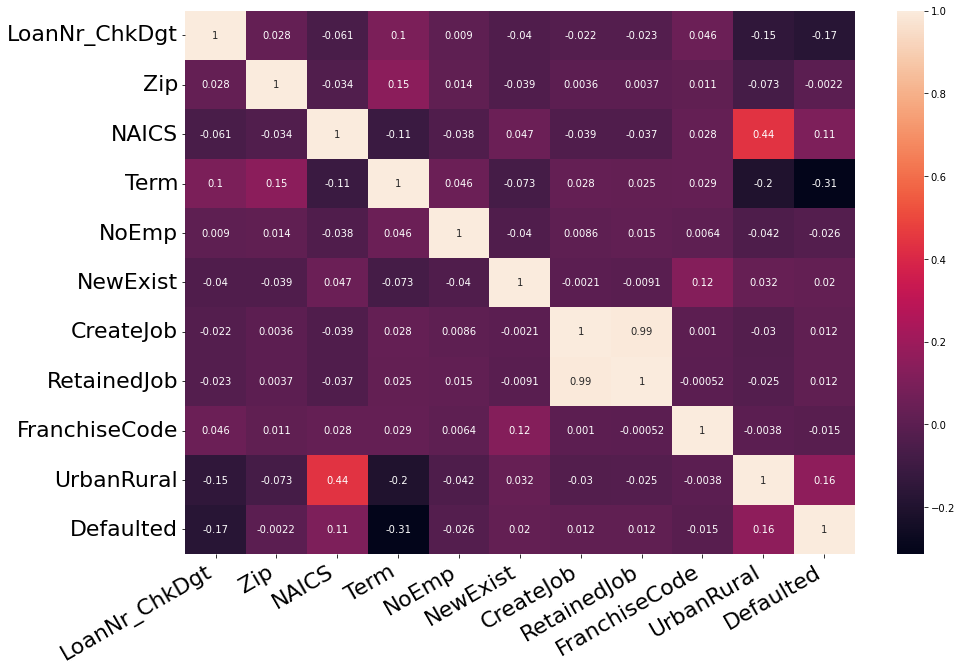

In [5]:
cor_fig, cor_ax = plt.subplots(figsize=(15, 10))
# we nneded to make MIS_Status binary in order to display it in the correlation matrix
# it is a part of the data preparation
df['Defaulted'] = [1 if app == 'CHGOFF' else 0 for app in df.MIS_Status.values]
corr_matrix = df.corr()
cor_ax = sns.heatmap(corr_matrix, annot=True)
plt.xticks(rotation=30, horizontalalignment='right', fontsize=22)
plt.yticks(fontsize=22)

plt.savefig('correlation.png')
plt.show()

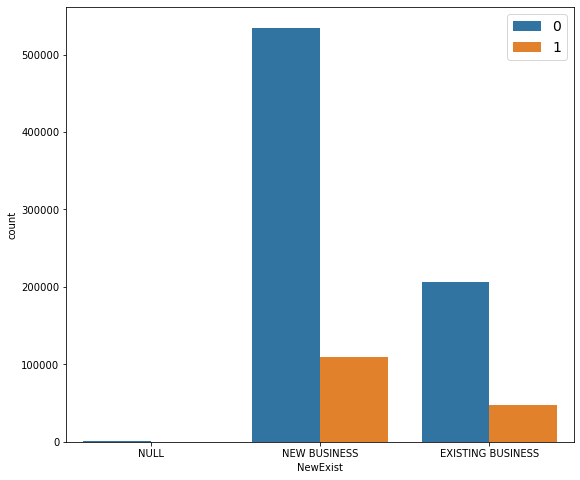

In [6]:
fig2 = plt.figure(figsize=(20,8))
ax1 = fig2.add_subplot(1, 2, 1)
plt.rcParams.update({'font.size': 14})
sns.countplot(x="NewExist", hue="Defaulted", data=df)
plt.legend()

labels = ("NULL", "NEW BUSINESS", "EXISTING BUSINESS")
positions = (0, 1, 2)
plt.xticks(positions, labels)
plt.savefig('new_exist.png')
plt.show()

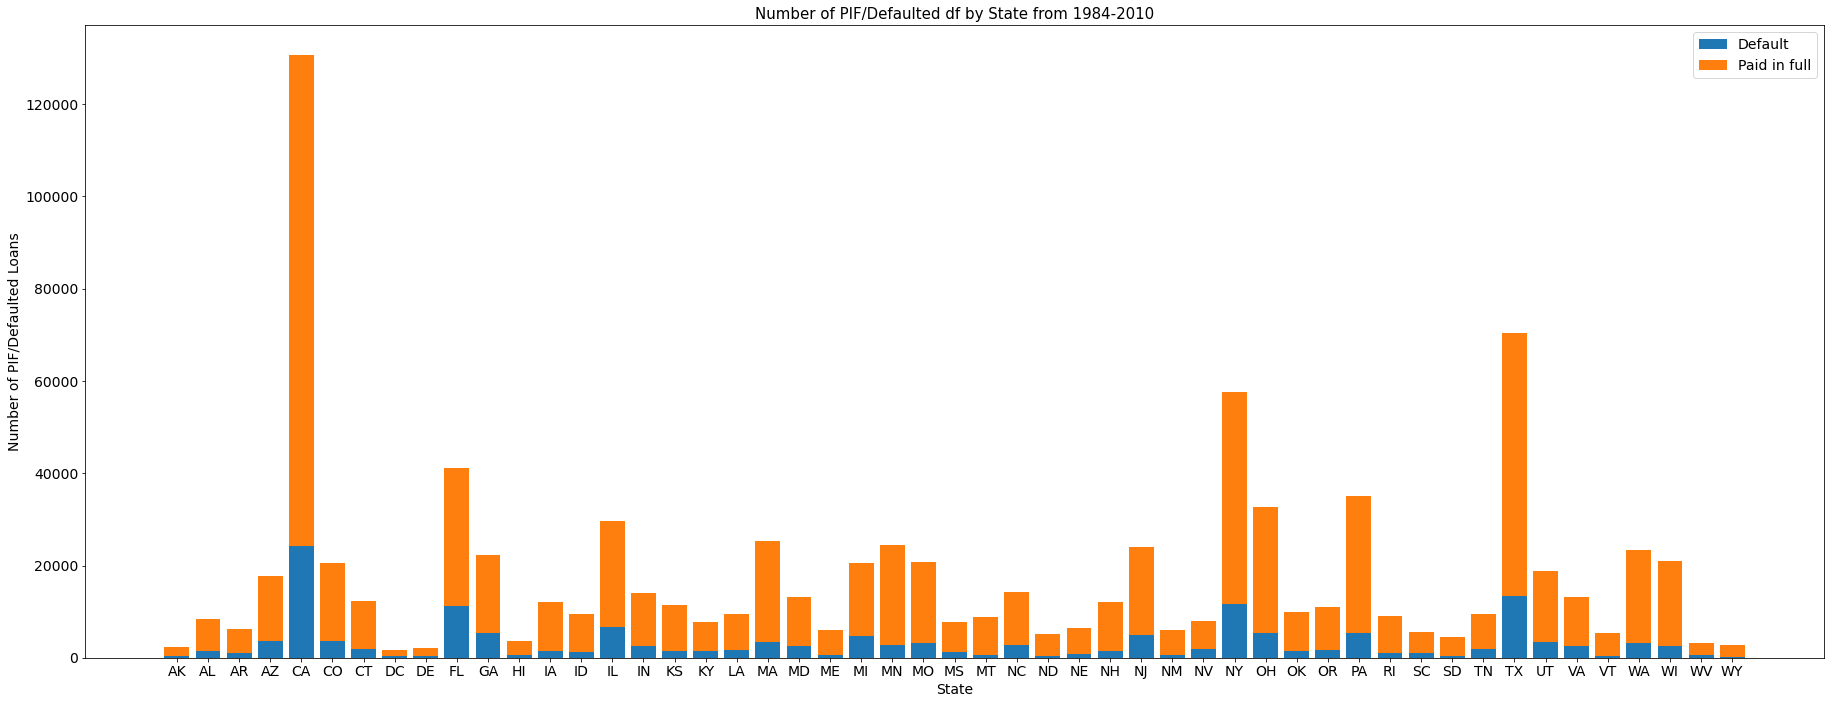

In [7]:
fig3 = plt.figure(figsize=(50, 10))

ax1 = fig3.add_subplot(1, 2, 1)

df = df.copy()

df['Default'] = np.where(df['MIS_Status'] == 'P I F', 0, 1)
df['Default'].value_counts()

data = df.groupby(['State', 'Default'])['State'].count().unstack('Default')
data.fillna(0)

ax1.bar(data.index, data[1], label='Default')
ax1.bar(data.index, data[0], bottom=data[1], label='Paid in full')

ax1.set_title('Number of PIF/Defaulted df by State from 1984-2010', fontsize=15)
ax1.set_xlabel('State')
ax1.set_ylabel('Number of PIF/Defaulted Loans')
ax1.legend()

plt.tight_layout()

plt.savefig('states.png')
plt.show()

In [8]:
df.columns

Index(['LoanNr_ChkDgt', 'Name', 'City', 'State', 'Zip', 'Bank', 'BankState',
       'NAICS', 'ApprovalDate', 'ApprovalFY', 'Term', 'NoEmp', 'NewExist',
       'CreateJob', 'RetainedJob', 'FranchiseCode', 'UrbanRural', 'RevLineCr',
       'LowDoc', 'ChgOffDate', 'DisbursementDate', 'DisbursementGross',
       'BalanceGross', 'MIS_Status', 'ChgOffPrinGr', 'GrAppv', 'SBA_Appv',
       'Defaulted', 'Default'],
      dtype='object')

# **Data Preparation**

In [9]:
# we want to make a binary value stating if the loan was defaulted or not
df = df.drop(columns=['MIS_Status'])

# we only take the loans created before 2007
df['ApprovalFY'] = df['ApprovalFY'].replace({'A':'','B':''}, regex = True).astype(int)
df.drop(df[df['ApprovalFY']>2007].index, axis = 0, inplace = True)

df = df.drop(columns=['ApprovalFY','ApprovalDate','DisbursementDate','ChgOffDate','LoanNr_ChkDgt','Name','Zip', 'City', 'Bank'])

In [10]:
df.head()

,State,BankState,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementGross,BalanceGross,ChgOffPrinGr,GrAppv,SBA_Appv,Defaulted,Default
0,IN,OH,451120,84,4,2.0,0,0,1,0,N,Y,"$60,000.00",$0.00,$0.00,"$60,000.00","$48,000.00",0,0
1,IN,IN,722410,60,2,2.0,0,0,1,0,N,Y,"$40,000.00",$0.00,$0.00,"$40,000.00","$32,000.00",0,0
2,IN,IN,621210,180,7,1.0,0,0,1,0,N,N,"$287,000.00",$0.00,$0.00,"$287,000.00","$215,250.00",0,0
3,OK,OK,0,60,2,1.0,0,0,1,0,N,Y,"$35,000.00",$0.00,$0.00,"$35,000.00","$28,000.00",0,0
4,FL,FL,0,240,14,1.0,7,7,1,0,N,N,"$229,000.00",$0.00,$0.00,"$229,000.00","$229,000.00",0,0


In [11]:
df.shape

(802319, 19)

In [12]:
def amount_to_float(number):
    num = number.replace("$", "")
    num = num.replace(",","")
    num = num.replace(" ","")
    return float(num)

#instead of dealing with money as a string we will deal with it as a number
df['BalanceGross'] = df['BalanceGross'].apply(lambda x: amount_to_float(x))
df['DisbursementGross'] = df['DisbursementGross'].apply(lambda x: amount_to_float(x))
df['ChgOffPrinGr'] = df['ChgOffPrinGr'].apply(lambda x: amount_to_float(x))
df['GrAppv'] = df['GrAppv'].apply(lambda x: amount_to_float(x))
df['SBA_Appv'] = df['SBA_Appv'].apply(lambda x: amount_to_float(x))

In [13]:
# we replace it to be a binary where 1 to be a new business and 0 an old business
df['NewExist'] = df['NewExist'].replace(1,0)
df['NewExist'] = df['NewExist'].replace(2,1)

In [14]:
# we replace the LowDoc values to be binary instead of Y and N
df['LowDoc'] = df['LowDoc'].replace({'Y':'1', 'N':'0'}, regex=True)
valid = ['1', '0']
df = df.loc[df['LowDoc'].isin(valid)]
df['LowDoc'] = df['LowDoc'].astype(int)

In [15]:
# we replace the RevLineCr values to be binary instead of Y and N
df['RevLineCr'] = df['RevLineCr'].replace({'Y':'1', 'N':'0'}, regex=True)
df = df.loc[df['RevLineCr'].isin(valid)]
df['RevLineCr'] = df['RevLineCr'].astype(int)

In [16]:
# we make FranchiseCode a binary column named Franchise where 1 is true and 0 is false
df['FranchiseCode'] = df['FranchiseCode'].replace(1,0)
df['FranchiseCode'] = np.where((df.FranchiseCode != 0),1,df.FranchiseCode)
df.rename(columns={"FranchiseCode":"Franchise"},inplace=True)

In [17]:
df.shape

(783512, 19)

In [18]:
# we get dummies for the catagorical columns BankState and State
df = pd.get_dummies(df,columns=['BankState','State'],prefix=['BankState','State'])

In [19]:
# only take the first 2 digits from the NAICS values
def first_n_digits(number, n):
    return int(str(number)[:n])
df['NAICS'] = df['NAICS'].apply(lambda x: first_n_digits(x,2))

In [20]:
df.head()

,NAICS,Term,NoEmp,NewExist,CreateJob,RetainedJob,Franchise,UrbanRural,RevLineCr,LowDoc,...,State_SD,State_TN,State_TX,State_UT,State_VA,State_VT,State_WA,State_WI,State_WV,State_WY
0,45,84,4,1.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,72,60,2,1.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,62,180,7,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,60,2,0.0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,240,14,0.0,7,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
df['NAICS'].unique()

array([45, 72, 62,  0, 33, 81, 23, 44, 42, 61, 53, 54, 31, 51, 71, 52, 21,
       32, 56, 48, 11, 92, 22, 49, 55])

In [22]:
df.columns

Index(['NAICS', 'Term', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
       'Franchise', 'UrbanRural', 'RevLineCr', 'LowDoc',
       ...
       'State_SD', 'State_TN', 'State_TX', 'State_UT', 'State_VA', 'State_VT',
       'State_WA', 'State_WI', 'State_WV', 'State_WY'],
      dtype='object', length=123)

In [23]:
df.dtypes

NAICS          int64
Term           int64
NoEmp          int64
NewExist     float64
CreateJob      int64
              ...   
State_VT       uint8
State_WA       uint8
State_WI       uint8
State_WV       uint8
State_WY       uint8
Length: 123, dtype: object

## Model selection and training

Here is where you will use the `scikit-learn` module to choose, load, and train your ML algorithm of choice. At this step, we will discuss which algorithm to use carefully, based on the task at hand (classification/regression/clustering), and maybe some more details pertaining to certain algorithms.


In [24]:
# 10 Popular Classificaiton Methods can be found here:
# https://www.educative.io/blog/scikit-learn-cheat-sheet-classification-regression-methods
# https://www.kaggle.com/code/ec200000/dsi-project#Modeling

y = df['Defaulted']
X = df.drop(columns=['Defaulted'])
y_backup = y
X = X.to_numpy()
y = pd.get_dummies(y)
y = y.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

In [25]:
# DT= DecisionTreeClassifier()
# DT.fit(X_train,y_train)

from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier()
RF.fit(X_train,y_train)

RandomForestClassifier()

In [26]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# We use the predict() on the model to predict the output
# pred=DT.predict(X_test)
pred=RF.predict(X_test)
 
# for classification we use accuracy and F1 score
print(accuracy_score(y_test,pred))
print(f1_score(y_test,pred,average='micro'))
 
# for regression we use R2 score and MAE(mean absolute error)
# all other steps will be same as classification as shown above
print(mean_absolute_error(y_test,pred))

0.9999693686886736
0.9999719212262766
0.003918255240506846


## Results presentation

This is the final step. Here, you will provide the outcomes of your analysis. These outcomes can be in the form of tables, plots, or both. 
As an extra step, you could also provide numerical results showing the efficiency of your model that can be described using specific ML characteristics:

 - accuracy
 - precision/recall
 - F1 score
 - Area Under Curve
 - ...

We will discuss further about those in class.